In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

import sys
sys.path.append('../ASC_AED_JoinTask/Datasets/')
sys.path.append('../ASC_AED_JoinTask/models/')
import ASC_datasets
import audio_utils as au

TUT_AUD_DIR = ASC_datasets.TUT_AUD_DIR
SAMPLE_RATE = 32000

In [139]:
csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds.csv'
df = pd.read_csv(csv)
scenes = df.scene_preds.unique()

In [140]:
at = AudioTagging(checkpoint_path='../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth', device='cuda')

def get_event_list(clipwise_output):
    # With the slicing, we are reversing the sorted index to get the descending order of event probs.
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    event_list = []

    # Creating a list of events with more than 0.05 prob
    for i in range(0, len(sorted_indexes)):
        event_prob = clipwise_output[sorted_indexes[i]]
        if event_prob > 0.1:
            event_list.append(np.array(labels)[sorted_indexes[i]])
    
    return event_list


def get_panns_events_list(audio):
    
    audio = audio[None, :]
    clipwise_op, embedding = at.inference(audio)

    event_list = get_event_list(clipwise_op[0])
    return event_list

Checkpoint path: ../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth
GPU number: 4


In [23]:
# Loop for predicting audio tags for the original audio
audio_tags_org = []

for i, row in df.iterrows():
    fname = os.path.join(TUT_AUD_DIR, row['files'])
    audio = au.load_audio_from_file(fname, sample_rate=SAMPLE_RATE)
    audio_tags_org.append(get_panns_events_list(audio))

In [27]:
df['audio_tags_org'] = audio_tags_org

In [141]:
audioset_ontology_df = pd.read_json('audioset_ontology.json')

def get_event_ids(event_id):
    idx = audioset_ontology_df[audioset_ontology_df['child_ids'].apply(lambda x: event_id in x)]
    if len(idx) > 0:
        return idx['id'].iloc[0]
    else:
        return 'None'
    
def get_immediate_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label

def get_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    while get_event_ids(parent_event_id) != 'None':
        parent_event_id = get_event_ids(parent_event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label


In [170]:
import ast

csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds_withOrgTags.csv'
df = pd.read_csv(csv)
scenes = df['labels'].unique()
df['audio_tags_org'] = df['audio_tags_org'].apply(lambda x: ast.literal_eval(x))

In [171]:
# Counting all the tags in the original audio
all_tags = set()

rearranged_filtered_tags = ['Outside, urban or manmade', 'Inside, public space', 'Wind', 'Recording', 'Ocean', 'Animal',
 'Human sounds', 'Human locomotion', 'Clip-clop', 'Rail transport', 'Vehicle', 'Music',
 'Aircraft', 'Rumble', 'Clickety-clack']

for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        all_tags.add(tag)

In [172]:
# PANNs unique audio tags and counts for each scene
scene_tag_counts = defaultdict(dict)
all_tags = list(all_tags)

for scene in scenes:
    for tag in all_tags:
        scene_tag_counts[scene][tag] = 0

In [173]:
# Counting the tags for each scene
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        scene_tag_counts[row['labels']][tag] += 1
        

In [174]:
# Counting the rearranged filtered tags
scene_filtered_tags_counts = defaultdict(dict)
for scene in scenes:
    for tag in rearranged_filtered_tags:
        scene_filtered_tags_counts[scene][tag] = 0

In [175]:
# Creating a dataframe
scene_tag_counts_df = pd.DataFrame.from_dict(scene_tag_counts)

# Normalizing the counts
for scene in scenes:
    # Here we normalized the counts using the total number of files for each scene
    # This gives us the number of times a tag was predicted against the total number of files for that scene
    # We then divide by the total number of files for that scene
        
        # THis approach worked out for the earlier idea, now the idea is to look at a subset of tags
    total = df['labels'].value_counts()[scene]

    for index in scene_tag_counts_df.index:
        #scene_tag_counts_df[scene][index] = (scene_tag_counts_df[scene][index])/total
        tag = index
        if (scene_tag_counts_df[scene][index])/total > 0.1:
            if index in rearranged_filtered_tags:
                scene_filtered_tags_counts[scene][index] += (scene_tag_counts_df[scene][index])
            else:
                print(index)
                while tag not in rearranged_filtered_tags:
                    tag = get_immediate_parent_class_label(tag)
                scene_filtered_tags_counts[scene][tag] += (scene_tag_counts_df[scene][index])


Train
Car
Hubbub, speech noise, speech babble
Run
Traffic noise, roadway noise
Subway, metro, underground
Railroad car, train wagon
Speech
Train
Car
Field recording
Bus
Motor vehicle (road)
Railroad car, train wagon
Speech
Train
Car
Bus
Fixed-wing aircraft, airplane
Subway, metro, underground
Railroad car, train wagon
Speech
Train
Bus
Subway, metro, underground
Railroad car, train wagon
Train wheels squealing
Speech
Car
Field recording
Fixed-wing aircraft, airplane
Boat, Water vehicle
Duck
Speech
Car
Ship
Field recording
Hubbub, speech noise, speech babble
Wind noise (microphone)
Fixed-wing aircraft, airplane
Traffic noise, roadway noise
Boat, Water vehicle
Waves, surf
Speech
Train
Subway, metro, underground
Railroad car, train wagon
Speech
Train
Car
Hubbub, speech noise, speech babble
Traffic noise, roadway noise
Speech
Car
Truck
Field recording
Bus
Motor vehicle (road)
Traffic noise, roadway noise
Boat, Water vehicle
Speech
Train
Car
Field recording
Bus
Subway, metro, underground
Rai

In [176]:
# Normalizing the filtered tags
scene_filtered_tags_counts_df = pd.DataFrame.from_dict(scene_filtered_tags_counts)

for scene in scenes:
    total = scene_filtered_tags_counts_df[scene].sum()
    #total = df['labels'].value_counts()[scene]
    for index in scene_filtered_tags_counts_df.index:
        scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total

/tmp/ipykernel_280467/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06726907630522089' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_280467/2578130740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_280467/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.057624113475177305' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<Axes: >

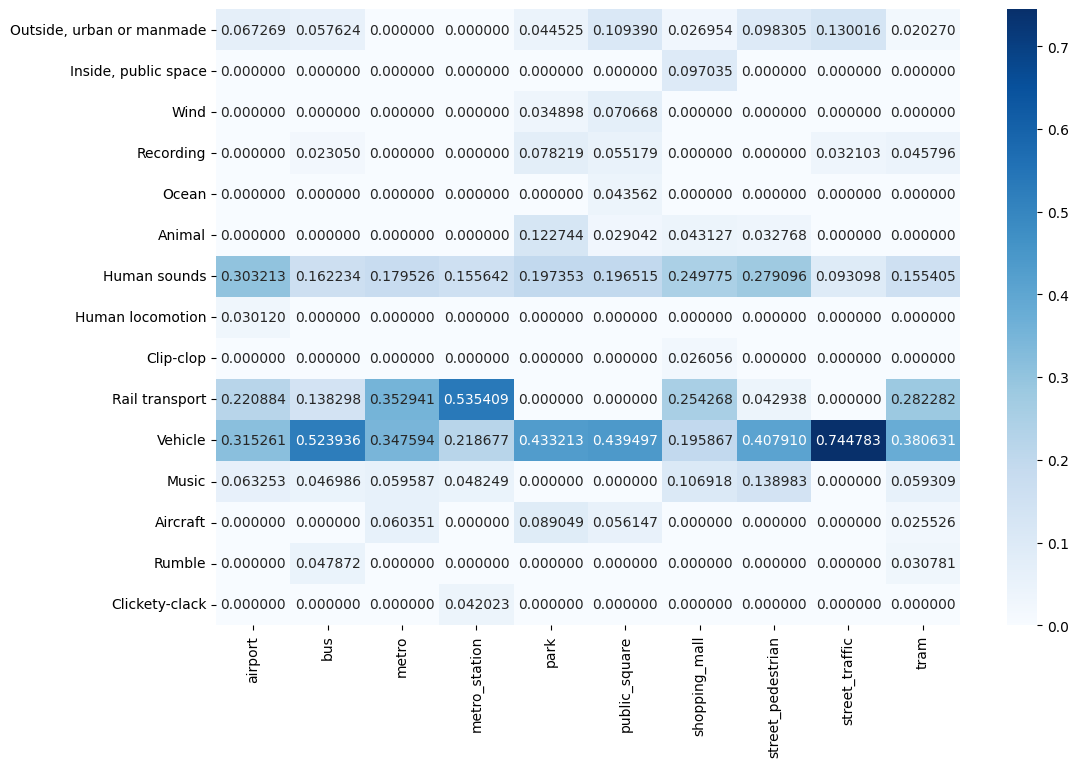

In [177]:
plt.figure(figsize=(12,8))
sns.heatmap(scene_filtered_tags_counts_df, fmt='f', annot=True, cmap='Blues')

In [204]:
# Now we want to understand the model behavior for all the correctly predicted scene labels
# We will use the audio tags from the original dataset to understand the patterns that the model might have observed
correct_scene_tags_count = defaultdict(dict)
correct_scene_filtered_tags_count = defaultdict(dict)
# Initialiing the dict
for scene in scenes:
    for tag in all_tags:
        correct_scene_tags_count[scene][tag] = 0
    for tag in rearranged_filtered_tags:
        correct_scene_filtered_tags_count[scene][tag] = 0
# Counting
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    #if row['labels'] != row['scene_preds']:
    for tag in tags:
        correct_scene_tags_count[row['scene_preds']][tag] += 1

# Counting the filtered tags for correctly predicted scenes
for scene in scenes:
    #total = len(df[df['labels'] == scene][df['scene_preds']!=scene])
    total = len(df[df['scene_preds']==scene])
    for tag in all_tags:
        index = tag
        if (correct_scene_tags_count[scene][tag])/total > 0.14:
            if tag in rearranged_filtered_tags:
                correct_scene_filtered_tags_count[scene][tag] += (correct_scene_tags_count[scene][tag])
            else:
                print(scene,index)
                while index not in rearranged_filtered_tags:
                    index = get_immediate_parent_class_label(index)
                correct_scene_filtered_tags_count[scene][index] += (correct_scene_tags_count[scene][tag])


airport Car
airport Hubbub, speech noise, speech babble
airport Run
airport Traffic noise, roadway noise
airport Boat, Water vehicle
airport Speech
bus Train
bus Car
bus Bus
bus Speech
metro Train
metro Car
metro Bus
metro Subway, metro, underground
metro Railroad car, train wagon
metro Speech
metro_station Train
metro_station Car
metro_station Bus
metro_station Traffic noise, roadway noise
metro_station Subway, metro, underground
metro_station Railroad car, train wagon
metro_station Speech
park Car
park Field recording
park Speech
public_square Car
public_square Bus
public_square Speech
shopping_mall Train
shopping_mall Subway, metro, underground
shopping_mall Speech
street_pedestrian Car
street_pedestrian Speech
street_traffic Car
street_traffic Truck
street_traffic Field recording
street_traffic Bus
street_traffic Motor vehicle (road)
street_traffic Traffic noise, roadway noise
street_traffic Speech
tram Train
tram Car
tram Field recording
tram Bus
tram Speech


In [205]:
# Normalizing the filtered tags
correct_scene_filtered_tags_count_df = pd.DataFrame.from_dict(correct_scene_filtered_tags_count)

for scene in scenes:
    total = correct_scene_filtered_tags_count_df[scene].sum()
    #total = df['labels'].value_counts()[scene]
    for index in scene_filtered_tags_counts_df.index:
        correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total

/tmp/ipykernel_280467/437944102.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total
/tmp/ipykernel_280467/437944102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total
/tmp/ipykernel_280467/437944102.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06318082788671024' has dtype incompatible with int64, please explicitly cast to a compatible d

<Axes: >

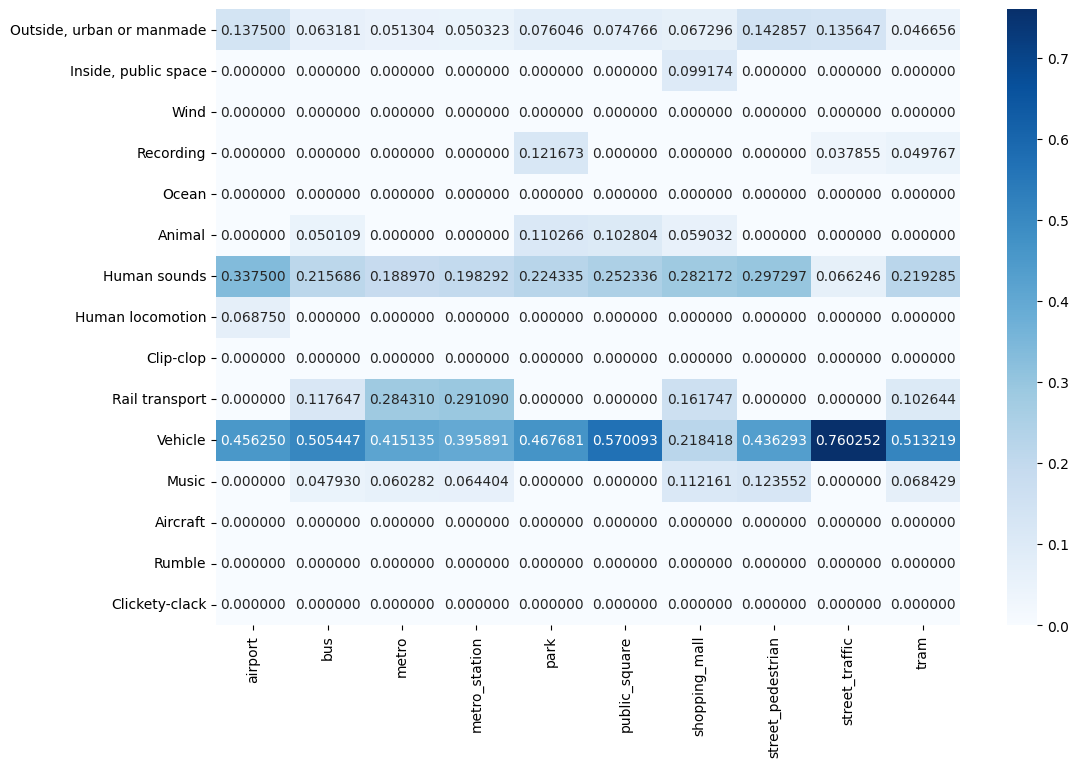

In [206]:
plt.figure(figsize=(12,8))
sns.heatmap(correct_scene_filtered_tags_count_df, fmt='f', annot=True, cmap='Blues')

<Axes: >

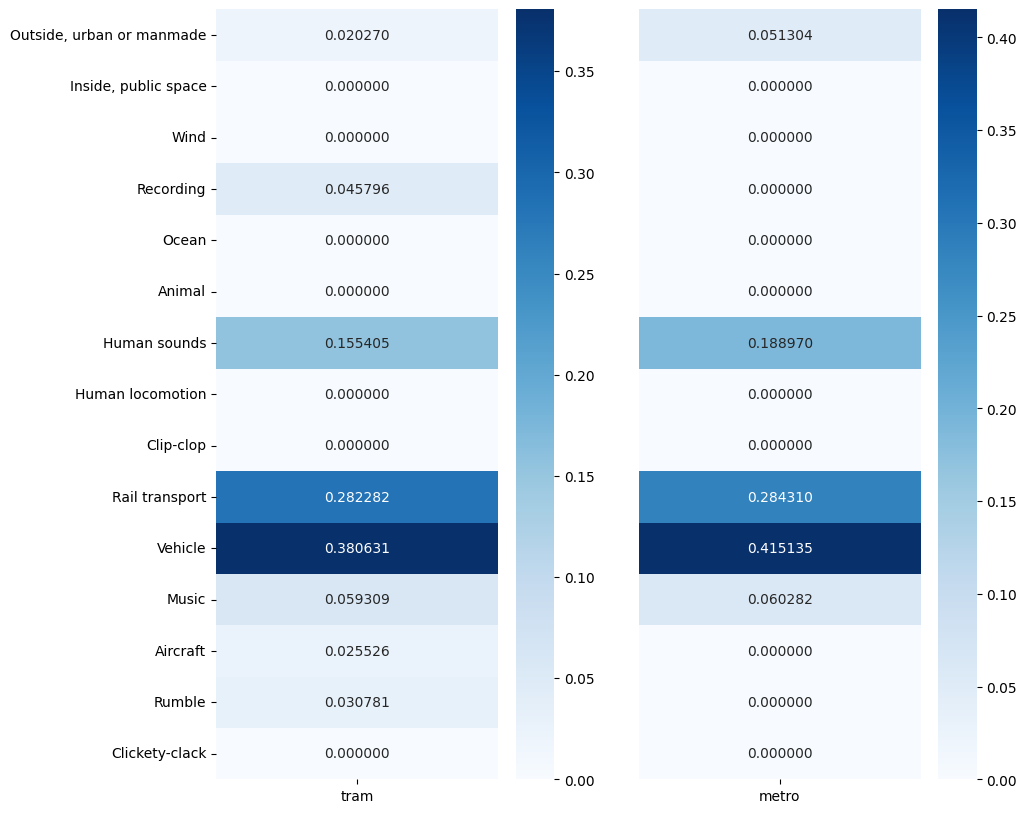

In [213]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
sns.heatmap(scene_filtered_tags_counts_df[['tram']], fmt='f', annot=True, cmap='Blues')
plt.subplot(1, 2, 2)
sns.heatmap(correct_scene_filtered_tags_count_df[['metro']], fmt='f', annot=True, cmap='Blues', yticklabels=False)

<Axes: >

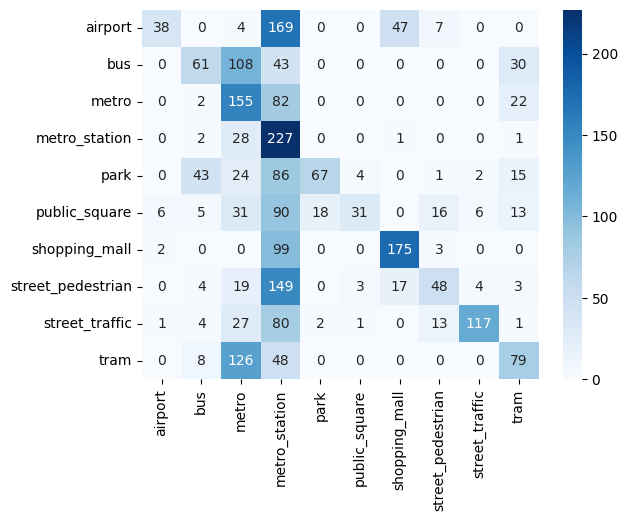

In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['labels'], df['scene_preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=scenes, yticklabels=scenes)